In [1]:
import torch
print(torch.cuda.is_available())

True


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
# out look of the model
batch_size = 64
Number_of_images = 100
Image_size = (40, 800)
Image_embedding_size = 8
Image_length = 100
Text_embedding_size = 228
Max_Number_of_Words = 45


# Decoder parameters
Layers = 2

E_TO_D_Input_size = Image_embedding_size
E_TO_D_output_size = 64

D_Input_size = 64
D_output_size = 64

D_To_Output_Input_size = 64
D_To_Output_output_size = Text_embedding_size


# reverse Embedding parameters
Reverse_Input_size = Text_embedding_size
Reverse_output_size = Text_embedding_size 

drop_prob = 0.2

True


In [3]:
from torch.utils.data import Dataset, DataLoader
import torch
import os

class TeluguOCRDataset(Dataset):
    def __init__(self, image_file_path, label_file_path):
        self.image_file_path = image_file_path
        self.label_file_path = label_file_path
    
    def __len__(self):
        return len(os.listdir(self.image_file_path))

    def __getitem__(self, index):
        image = torch.load(os.path.join(self.image_file_path, "Image"+str(index+1) + '.pt'))
        label = torch.load(os.path.join(self.label_file_path, "Label"+str(index+1) + '.pt'))

        new_image = torch.zeros((1, 40, 800))
        new_label = torch.zeros((45, 9))

        new_image[0, :, :image.shape[1]] = image
        new_label[:label.shape[0], :] = label

        return new_image, new_label, len(label), int(image.shape[1]/(9))

In [4]:
# CNN model
class EncoderCNN(nn.Module):
    def __init__(self) -> None:
        super(EncoderCNN, self).__init__()

        self.conv_seq11 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3)),
            nn.Dropout2d(drop_prob),
            nn.BatchNorm2d(16),
            nn.SiLU(),
        )

        self.conv_seq12 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.Dropout2d(drop_prob),
            nn.BatchNorm2d(16),
            nn.SiLU(),
        )

        self.conv_seq21 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3)),
            nn.Dropout2d(drop_prob),
            nn.BatchNorm2d(64),
            nn.SiLU(),
        )
        
        self.conv_seq22 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.Dropout2d(drop_prob),
            nn.BatchNorm2d(64),
            nn.SiLU(),
        )

        self.conv_seq31 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3)),
            nn.Dropout2d(drop_prob),
            nn.BatchNorm2d(128),
            nn.SiLU(),
        )
        
        self.conv_seq32 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.Dropout2d(drop_prob),
            nn.BatchNorm2d(128),
            nn.SiLU(),
        )

        # initializing weights of conv layers with he_normal
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight.data)
                nn.init.constant_(m.bias.data, 0)

        self.Linear_seq = nn.Sequential(
            nn.Linear(128*5, 320),
            nn.ReLU(),
            nn.Linear(320, 160),
            nn.ReLU(),
            nn.Linear(160, 80),
            nn.ReLU(),
            nn.Linear(80, 40),
            nn.ReLU(),
            nn.Linear(40, 20),
            nn.ReLU(),
            nn.Linear(20, Image_embedding_size)
        )

        #initializing weights of linear layers with Xavier normal
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight.data)
                nn.init.constant_(m.bias.data, 0)

    def forward(self, x):
        x = self.conv_seq11(x) + self.conv_seq12(x)
        x = self.conv_seq21(x) + self.conv_seq22(x)
        x = self.conv_seq31(x) + self.conv_seq32(x)

        x = x.reshape(x.shape[0], 640, 100)
        xx = []
        for i in range(x.shape[0]):
            t = x[i]  # Fixed indexing here
            t = t.T
            xx.append(t)

        xx = torch.stack(xx)  # Use torch.stack to preserve batch dimension
#         print(type(xx), len(xx), xx[0].shape)
        x = self.Linear_seq(xx)
#         print(x.shape,x.shape)
        return x
    
# Img1 = torch.randn(64, 1, 40, 800).to(device)
# model = EncoderCNN().to(device)
# output1 = model(Img1)
# print(output1.shape)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features, prior_var=0.02):
        super(BayesianLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.prior_var = prior_var
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features))
        self.weight_rho = nn.Parameter(torch.Tensor(out_features, in_features))
        self.bias_mu = nn.Parameter(torch.Tensor(out_features))
        self.bias_rho = nn.Parameter(torch.Tensor(out_features))

        self.weight_mu.requires_grad = True
        self.weight_rho.requires_grad = True
        self.bias_mu.requires_grad = True
        self.bias_rho.requires_grad = True

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_normal_(self.weight_mu)
        nn.init.constant_(self.weight_rho, -10)
        nn.init.zeros_(self.bias_mu)
        nn.init.constant_(self.bias_rho, -10)

    def forward(self, x):
        weight_sigma = torch.log1p(torch.exp(self.weight_rho))
        bias_sigma = torch.log1p(torch.exp(self.bias_rho))
        epsilon_weight = torch.randn_like(weight_sigma)
        epsilon_bias = torch.randn_like(bias_sigma)
        weight = self.weight_mu + weight_sigma * epsilon_weight
        bias = self.bias_mu + bias_sigma * epsilon_bias
        return F.linear(x, weight, bias)

    def kl_divergence(self):
        weight_sigma = torch.log1p(torch.exp(self.weight_rho))
        bias_sigma = torch.log1p(torch.exp(self.bias_rho))
        weight_var = weight_sigma ** 2
        bias_var = bias_sigma ** 2
        weight_kl = 0.5 * (weight_var + self.weight_mu ** 2 - 1 - weight_sigma)
        bias_kl = 0.5 * (bias_var + self.bias_mu ** 2 - 1 - bias_sigma)
        return weight_kl.sum() + bias_kl.sum()

In [30]:
class DECODER_RNN(nn.Module):
    def __init__(self) -> None:
        super(DECODER_RNN, self).__init__()

        #----------------------------------------------LSTM------------------------------------
        self.lstm1 = nn.LSTM(input_size=E_TO_D_Input_size, hidden_size=int(D_To_Output_output_size / 2), num_layers=Layers, bidirectional=True, batch_first=True) #100 to 364
        self.lstm2 = nn.LSTM(input_size=E_TO_D_Input_size, hidden_size=int(D_To_Output_output_size / 2), num_layers=Layers, bidirectional=True, batch_first=True) #512 to 512

        self.concat_Linear = nn.Sequential(
            nn.Linear(D_To_Output_output_size * 2, D_To_Output_output_size),
        )

        # reverse embedder
        self.Linear_seq2 = nn.Sequential(
            nn.Linear(D_To_Output_output_size, Text_embedding_size)
        )

        # Initializing weights with Xavier normal.
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight.data)
                nn.init.constant_(m.bias.data, 0)
            if isinstance(m, nn.GRU):
                for name, param in m.named_parameters():
                    if 'weight' in name:
                        nn.init.xavier_normal_(param.data)
                    else:
                        nn.init.constant_(param.data, 0)
            if isinstance(m, nn.LSTM):
                for name, param in m.named_parameters():
                    if 'weight' in name:
                        nn.init.xavier_normal_(param.data)
                    else:
                        nn.init.constant_(param.data, 0)
            if isinstance(m, nn.TransformerEncoderLayer):
                for name, param in m.named_parameters():
                    if 'weight' in name and param.data.dim() > 1:
                        nn.init.xavier_normal_(param.data)
                    else:
                        nn.init.constant_(param.data, 0)

    def initialise_hidden_states(self, batch_size):
        # --------------------------Hidden states for LSTM-----------------------------------------
        self.hidden1 = (torch.zeros(2 * Layers, batch_size, int(D_To_Output_output_size / 2)).to(device),
                        torch.zeros(2 * Layers, batch_size, int(D_To_Output_output_size / 2)).to(device))
        self.hidden2 = (torch.zeros(2 * Layers, batch_size, int(D_To_Output_output_size / 2)).to(device),
                        torch.zeros(2 * Layers, batch_size, int(D_To_Output_output_size / 2)).to(device))

    def forward(self, x):
        self.initialise_hidden_states(x.shape[0])
        outputs1, (h_n1, c_n1) = self.lstm1(x, self.hidden1)
        outputs2, (h_n2, c_n2) = self.lstm2(x, self.hidden2)
        
        outputs = torch.cat((outputs1, outputs2), dim=2)  # Concatenate along the feature dimension
        
        outputs = self.concat_Linear(outputs)
        outputs = self.Linear_seq2(outputs).permute(1, 0, 2)
        
        return outputs


In [63]:

def Epoch_Run(encoder, decoder, dataloader, optimizer, criterion, training = True):
    if training:
        encoder.train()
        decoder.train()
    else:
        encoder.eval()
        decoder.eval()
    
    epoch_loss = 0

    idx = 1

    for images, labels, target_lengths, input_lengths in dataloader:
        if training:
            print("T: ", idx, end = "\r")
        else:
            print("V: ", idx, end = "\r")

        idx+=1
        images = images.to(device)
        labels = labels.to(device)
        target_lengths = target_lengths.to(device)
        input_lengths = input_lengths.to(device)

        # Encoder

#         ENC_output = encoder(images).unsqueeze(1)
        ENC_output = encoder(images)
        
        
        Dec_Out = decoder(ENC_output)

        # applying log_softmax
        
        Dec_Out_log_softmax = Dec_Out.clone()
        Dec_Out_log_softmax[:, :, 0:110] = F.log_softmax(Dec_Out[:, :, 0:110], dim=2)
        Dec_Out_log_softmax[:, :, 110:131] = F.log_softmax(Dec_Out[:, :, 110:131], dim=2)
        Dec_Out_log_softmax[:, :, 131:152] = F.log_softmax(Dec_Out[:, :, 131:152], dim=2)
        Dec_Out_log_softmax[:, :, 152:190] = F.log_softmax(Dec_Out[:, :, 152:190], dim=2)
        Dec_Out_log_softmax[:, :, 190:228] = F.log_softmax(Dec_Out[:, :, 190:228], dim=2)

        input_lengths = torch.full(size=(images.shape[0],), fill_value=100, dtype=torch.long).to(device)

        Loss = 0
        # for base
        Loss += criterion(Dec_Out_log_softmax[:, :, 0:110], labels[:, :, 0], input_lengths, target_lengths)

        # for vm1
        Loss += criterion(Dec_Out_log_softmax[:, :, 110:131], labels[:, :, 1], input_lengths, target_lengths)

        # for vm2
        Loss += criterion(Dec_Out_log_softmax[:, :, 131:152], labels[:, :, 2], input_lengths, target_lengths)

        # for cm1
        Loss += criterion(Dec_Out_log_softmax[:, :, 152:190], labels[:, :, 5], input_lengths, target_lengths)

        # for cm2
        Loss += criterion(Dec_Out_log_softmax[:, :, 190:228], labels[:, :, 6], input_lengths, target_lengths)

        
        if training:
            optimizer.zero_grad()
            Loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        epoch_loss += Loss.item()

    return epoch_loss

Epoch :  1  | Loss :  7.537693615936477  | Validation Loss :  6.59557450159319  | Time :  223.06696248054504
Epoch :  2  | Loss :  6.33233083814812  | Validation Loss :  5.177405566558718  | Time :  223.4921271800995
Epoch :  3  | Loss :  2.414268988732537  | Validation Loss :  0.9670335827722483  | Time :  223.4094944000244
Epoch :  4  | Loss :  0.7514215801130627  | Validation Loss :  0.5906333198538855  | Time :  227.7383849620819
Epoch :  5  | Loss :  0.472809021847876  | Validation Loss :  0.3940205612854773  | Time :  225.76605892181396
Epoch :  6  | Loss :  0.3707255202387813  | Validation Loss :  0.37539297991723164  | Time :  222.86366033554077
Epoch :  7  | Loss :  0.31574122791270687  | Validation Loss :  0.3132228236859414  | Time :  218.91857981681824
Epoch :  8  | Loss :  0.2815009225559146  | Validation Loss :  0.2967414613204536  | Time :  218.28607416152954
Epoch :  9  | Loss :  0.26082405733612674  | Validation Loss :  0.2882861631350253  | Time :  218.46483540534973


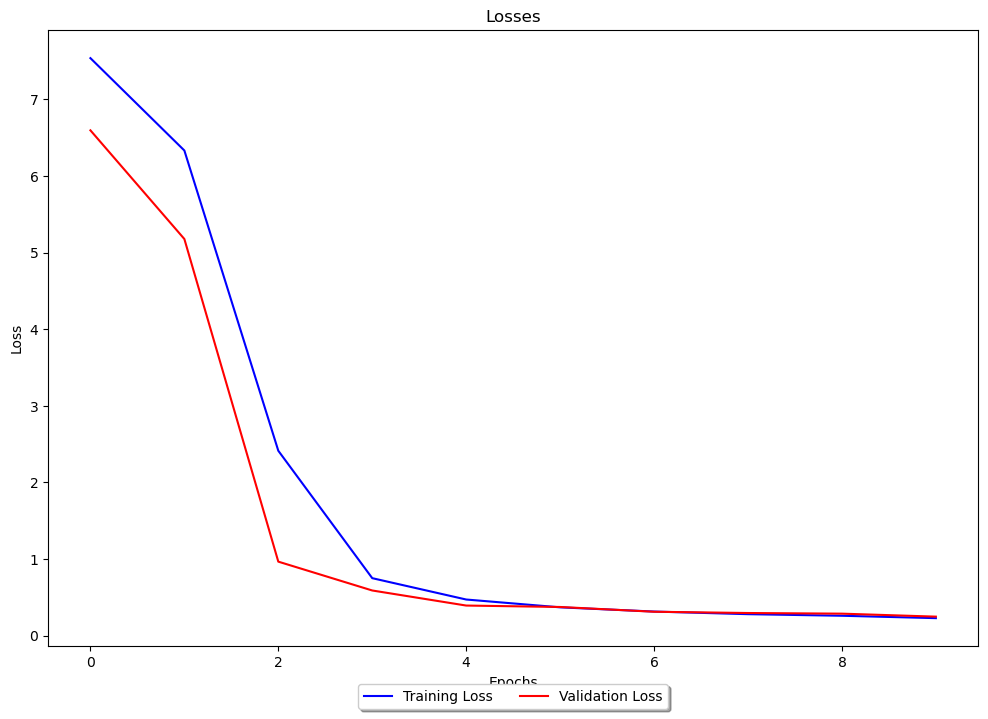

In [32]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.cuda.empty_cache()
cnn = EncoderCNN().to(device)
decoder = DECODER_RNN().to(device)

torch.autograd.set_detect_anomaly(True)
criterion = nn.CTCLoss(blank=0, zero_infinity=True, reduction = 'mean') if torch.cuda.is_available() else nn.CTCLoss(blank=0, zero_infinity=True, reduction = 'mean')

params = list(cnn.parameters()) + list(decoder.parameters())
optimizer = torch.optim.Adam(params, lr=1e-3, weight_decay=1e-5)

clip = 5
torch.nn.utils.clip_grad_norm_(params, clip)

num_of_epochs = 10

Losses = []
val_losses = []

save_num = 1

dataset = TeluguOCRDataset(r"C:/Users/Varun Gopal/Desktop/TeluguOCR_MLProject/KLA_Intern/Dataset/Cropped_Dataset/Images", r"C:/Users/Varun Gopal/Desktop/TeluguOCR_MLProject/KLA_Intern/Dataset/Cropped_Dataset/Labels")

# splitting the dataset into training and validation
torch.manual_seed(0)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.7, 0.3])

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

for epoch in range(1, num_of_epochs + 1):
    start_time = time.time()
    # training
    epoch_loss = Epoch_Run(cnn, decoder, train_dataloader, optimizer, criterion, training = True)
    # validation
    val_loss = Epoch_Run(cnn, decoder, val_dataloader, optimizer, criterion, training = False)
    print("Epoch : ", epoch, " | Loss : ", (epoch_loss*64)/len(train_dataset), " | Validation Loss : ", (val_loss*64)/len(val_dataset), " | Time : ", time.time() - start_time)
    Losses.append((epoch_loss*64)/len(train_dataset))
    val_losses.append((val_loss*64)/len(val_dataset))
        

# Plotting the losses
plt.figure(figsize=(12, 8))
plt.plot(Losses, label = "Training Loss", color = 'blue')
plt.plot(val_losses, label = "Validation Loss", color = 'red')
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.05),
    shadow=True,
    ncol=2
)
plt.title("Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig(r"C:/Users/Varun Gopal/Desktop/TeluguOCR_MLProject/KLA_Intern/Losses_GRU1.png")      

In [62]:
torch.cuda.empty_cache()

In [184]:
index = 110
image = torch.load(os.path.join(r"C:/Users/Varun Gopal/Desktop/TeluguOCR_MLProject/KLA_Intern/Dataset/Cropped_Dataset/Images", "Image"+str(index+1) + '.pt')).to(torch.float32).to(device)
label = torch.load(os.path.join(r"C:/Users/Varun Gopal/Desktop/TeluguOCR_MLProject/KLA_Intern/Dataset/Cropped_Dataset/Labels", "Label"+str(index+1) + '.pt'))

new_image = torch.zeros((1, 40, 800))
new_label = torch.zeros((45, 9))

new_image[0, :, :image.shape[1]] = image
new_label[:label.shape[0], :] = label

In [185]:
plt.imshow(np.array(image))
print(image.shape)
# for image,label,j,l in train_dataset:
#     print(image.shape)
len(dataset) 

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [186]:
cnn(image.unsqueeze(0))

ValueError: expected 4D input (got 3D input)

In [36]:
from torchvision import datasets
from torch.utils.data import Dataset,DataLoader
from torchvision.utils import save_image
from skimage.util import random_noise
from PIL import Image
!pip install augraphy
from augraphy import *
import numpy as np
import torch
import torchvision.transforms as transforms
import os
import random
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


dir = r'C:\Users\Varun Gopal\Desktop\TeluguOCR_MLProject\KLA_Intern\Dataset\Images'
NoiseImagePath = r'C:\Users\Varun Gopal\Desktop\TeluguOCR_MLProject\KLA_Intern\Dataset\Cropped_Dataset\Images'
NoiseLabelPath = r'C:\Users\Varun Gopal\Desktop\TeluguOCR_MLProject\KLA_Intern\Dataset\Cropped_Dataset\Labels'

# Define the transformation to convert the images to tensors and perform any other necessary preprocessing
transform = transforms.Compose([
    transforms.ToPILImage(),  # Ensure PIL
    transforms.Grayscale(num_output_channels=1),  # Convert to single channel greyscale
    transforms.ToTensor()  # Convert to a PyTorch tensor
])


acchulu = ['అ', 'ఆ', 'ఇ', 'ఈ', 'ఉ', 'ఊ', 'ఋ', 'ౠ', 'ఌ', 'ౡ', 'ఎ', 'ఏ', 'ఐ', 'ఒ', 'ఓ', 'ఔ', 'అం', 'అః']
hallulu = ['క', 'ఖ', 'గ', 'ఘ', 'ఙ',
           'చ', 'ఛ', 'జ', 'ఝ', 'ఞ',
           'ట', 'ఠ', 'డ', 'ఢ', 'ణ',
           'త', 'థ', 'ద', 'ధ', 'న',
           'ప', 'ఫ', 'బ', 'భ', 'మ',
           'య', 'ర', 'ల', 'వ', 'శ', 'ష', 'స', 'హ', 'ళ', 'క్ష', 'ఱ']
vallulu = ['ా', 'ి', 'ీ', 'ు' , 'ూ', 'ృ', 'ౄ', 'ె', 'ే', 'ై', 'ొ', 'ో', 'ౌ', 'ం', 'ః', 'ఁ', 'ౕ', 'ౖ', 'ౢ']
connector = ['్']
numbers = ['౦', '౧', '౨', '౩', '౪', '౫', '౬', '౭', '౮', '౯']
splcharacters= [' ', '!', '"', '#', '$', '%', '&', "'", '(', ')',
              '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[',
              '\\', ']', '^', '_', '`', '{', '|', '}', '~', '1','2', '3', '4', '5', '6', '7', '8', '9', '0', 'ఽ']
spl = splcharacters + numbers

bases = acchulu + hallulu + spl
vms = vallulu
cms = hallulu

print("Bases: ", len(bases))
print("Vms: ", len(vms))
print("Cms: ", len(cms))

characters = bases+vms+cms+connector

base_mapping = {}
i = 2
for x in bases:
  base_mapping[x] = i
  i+=1

vm_mapping = {}
i = 2
for x in vms:
  vm_mapping[x] = i
  i+=1

cm_mapping = {}
i = 2
for x in cms:
  cm_mapping[x] = i
  i+=1

  
# creates a list of dictionaries with each dictionary reporesenting a term
def wordsDicts(s):
  List = []
  for i in range(len(s)):
    x = s[i]
    prev = ''
    if i > 0: prev = s[i-1]
    #----------------------------------is it a base term-----------------------
    if((x in acchulu or x in hallulu)  and prev != connector[0]):
      List.append({})
      List[-1]['base'] = x
    #----------------------------if it is a consonant modifier-----------------
    elif x in hallulu and prev == connector[0]:
      if(len(List) == 0):
        print(x)
      if('cm' not in List[-1]): List[-1]['cm'] = []
      List[len(List)-1]['cm'].append(x)

      #---------------------------if it is a vowel modifier--------------------
    elif x in vallulu:
      if(len(List) == 0):
        print(x)

      if('vm' not in List[-1]): List[-1]['vm'] = []
      List[len(List)-1]['vm'].append(x)

      #----------------------------it is a spl character-----------------------
    elif x in spl:
      List.append({})
      List[len(List)-1]['base'] = x
    else:
      continue
  return List


def index_encoding(s):
  List = wordsDicts(s)
  onehot = []
  for i in range(len(List)):
    D = List[i]
    onehotbase=  [1]
    onehotvm1 =  [1]
    onehotvm2 =  [1]
    onehotvm3 =  [1]
    onehotvm4 =  [1]
    onehotcm1 =  [1]
    onehotcm2 =  [1]
    onehotcm3 =  [1]
    onehotcm4 =  [1]


    onehotbase[0] = base_mapping[D['base']]

    it = 1
    if('vm' in D):
      for j in D['vm']:
        if it == 1:
          onehotvm1[0] = vm_mapping[j]
        elif it == 2:
          onehotvm2[0] = vm_mapping[j]
        elif it == 3:
          onehotvm3[0] = vm_mapping[j]
        elif it == 4:
          onehotvm4[0] = vm_mapping[j]
        it += 1
    
    it = 1
    if('cm' in D):
      for j in D['cm']:
        if it == 1:
          onehotcm1[0] = cm_mapping[j]
        elif it == 2:
          onehotcm2[0] = cm_mapping[j]
        elif it == 3:
          onehotcm3[0] = cm_mapping[j]
        elif it == 4:
          onehotcm4[0] = cm_mapping[j]
        it += 1
    onehoti = onehotbase + onehotvm1 + onehotvm2 + onehotvm3 + onehotvm4 + onehotcm1 + onehotcm2 + onehotcm3 + onehotcm4 #size 110 + 2*21 + 2*38 = 228
    onehot.append(onehoti)
  return torch.tensor(onehot)

def index_decoder(List):
  x = ""
  for onehoti in List:
    if onehoti[0] > 1:
      x += bases[onehoti[0]-2]

    if onehoti[5] > 1:
      x += connector[0]
      x += cms[onehoti[5]-2]
    if onehoti[6] > 1:
      x += connector[0]
      x += cms[onehoti[6]-2]
    if onehoti[7] > 1:
      x += connector[0]
      x += cms[onehoti[7]-2]
    if onehoti[8] > 1:
      x += connector[0]
      x += cms[onehoti[8]-2]

    if onehoti[1] > 1:
      x += vms[onehoti[1]-2]
    if onehoti[2] > 1:
      x += vms[onehoti[2]-2]
    if onehoti[3] > 1:
      x += vms[onehoti[3]-2]
    if onehoti[4] > 1:
      x += vms[onehoti[4]-2]
  return x



# Noise type 0
def add_gaussian_noise(img):
  img = transform(image)
  gauss_img = torch.tensor(random_noise(img, mode='gaussian', mean=0, var=0.02, clip=True))
  return gauss_img

# Noise type 1
inkbleed = InkBleed(intensity_range=(0.2, 1),
                    kernel_size=(5, 5),
                    severity=(0.2, 0.4)
                    )

# Noise type 2
doubleexposure = DoubleExposure(gaussian_kernel_range=(2,3),
                                offset_direction=1,
                                offset_range=(2,4),
                                )

# Noise type 3
hollow = Hollow(hollow_median_kernel_value_range = (51, 51),
                hollow_min_width_range=(1, 1),
                hollow_max_width_range=(15, 15),
                hollow_min_height_range=(1, 1),
                hollow_max_height_range=(15, 15),
                hollow_min_area_range=(10, 10),
                hollow_max_area_range=(50, 50),
                hollow_dilation_kernel_size_range = (3, 3),
                )

# Noise type 4
letterpress = Letterpress(n_samples=(20, 500),
                          n_clusters=(30, 80),
                          std_range=(150, 500),
                          value_range=(10, 15),
                          value_threshold_range=(128, 128),
                          blur=1
                          )

# Noise type 5
lighting_gradient_linear_static = LightingGradient(light_position=None,
                                              direction=45,
                                              max_brightness=150,
                                              min_brightness=50,
                                              mode="linear_static",
                                              linear_decay_rate = 0.5,
                                              transparency=0.5
                                              )

# Noise type 6
low_ink_periodic_line_consistent =  LowInkPeriodicLines(count_range=(1, 5),
                                                        period_range=(1, 4),
                                                        use_consistent_lines=False,
                                                        noise_probability=0.02,
                                                        )

# Noise type 7
shadowcast = ShadowCast(shadow_side = "bottom",
                        shadow_vertices_range = (2, 3),
                        shadow_width_range=(0.5, 0.8),
                        shadow_height_range=(0.5, 0.8),
                        shadow_color = (10, 10, 10),
                        shadow_opacity_range=(0.5,0.6),
                        shadow_iterations_range = (1,2),
                        shadow_blur_kernel_range = (101, 301),
                        )

# Noise type 8
folding = Folding(fold_count=3,
                  fold_noise=0.0,
                  fold_angle_range = (-360,360),
                  gradient_width=(0.1, 0.5),
                  gradient_height=(0.01, 0.05),
                  backdrop_color = (255,255,255),
                  )

# Noise type 9
book_binder_down = BookBinding(shadow_radius_range=(100, 100),
                              curve_range_right=(1, 1),
                              curve_range_left=(1, 1),
                              curve_ratio_right = (1e-5, 1e-5),
                              curve_ratio_left = (1e-5, 1e-5),
                              mirror_range=(0, 0),
                              binding_align = 2,
                              binding_pages = (4,6),
                              curling_direction=0,
                              backdrop_color=(255, 255, 255),
                              enable_shadow=1,
                              use_cache_images = 0,
                              )

# Noise type 10
inkshifter_obj = InkShifter(
    text_shift_scale_range=(2, 7),
    text_shift_factor_range=(1, 4),
    text_fade_range=(0, 2),
    noise_type = "random",
)


# load the txt file and read the file line by line.
def read_file_lines(filename):
    lines = []
    try:
        with open(filename, 'r', encoding='utf8') as file:
            for line in file:
                lines.append(line.strip())  # Remove trailing newline characters
    except FileNotFoundError:
        print(f"File '{filename}' not found.")
    except Exception as e:
        print(f"An error occurred: {str(e)}")
    return lines


lines = read_file_lines(r"C:\Users\Varun Gopal\Desktop\TeluguOCR_MLProject\KLA_Intern\Dataset\final_strings.txt")

num = 1
a = b = 0

types = []

print(len(lines),"is the length of lines list...")





Bases:  108
Vms:  19
Cms:  36
189530 is the length of lines list...


In [37]:
print(lines[0])

అగ్నిసూక్తం


In [38]:
list(lines[0])

['అ', 'గ', '్', 'న', 'ి', 'స', 'ూ', 'క', '్', 'త', 'ం']

In [39]:
wordsDicts('క్తం')

[{'base': 'క', 'cm': ['త'], 'vm': ['ం']}]

In [40]:
index_encoding(lines[100]).shape

torch.Size([19, 9])

In [41]:
lines[100]

'యదంగ దాశుషే త్వమగ్నే భద్రం కరిష్యసి'

In [42]:
acchulu[0]

'అ'

In [43]:
bases[20]

'గ'

In [44]:
index_decoder(index_encoding(lines[0]))

'అగ్నిసూక్తం'

In [45]:
index_encoding(lines[100])

tensor([[45,  1,  1,  1,  1,  1,  1,  1,  1],
        [37, 15,  1,  1,  1,  1,  1,  1,  1],
        [22,  1,  1,  1,  1,  1,  1,  1,  1],
        [56,  1,  1,  1,  1,  1,  1,  1,  1],
        [37,  2,  1,  1,  1,  1,  1,  1,  1],
        [49,  5,  1,  1,  1,  1,  1,  1,  1],
        [50, 10,  1,  1,  1,  1,  1,  1,  1],
        [56,  1,  1,  1,  1,  1,  1,  1,  1],
        [35,  1,  1,  1,  1, 30,  1,  1,  1],
        [44,  1,  1,  1,  1,  1,  1,  1,  1],
        [22, 10,  1,  1,  1, 21,  1,  1,  1],
        [56,  1,  1,  1,  1,  1,  1,  1,  1],
        [43,  1,  1,  1,  1,  1,  1,  1,  1],
        [37, 15,  1,  1,  1, 28,  1,  1,  1],
        [56,  1,  1,  1,  1,  1,  1,  1,  1],
        [20,  1,  1,  1,  1,  1,  1,  1,  1],
        [46,  3,  1,  1,  1,  1,  1,  1,  1],
        [50,  1,  1,  1,  1, 27,  1,  1,  1],
        [51,  3,  1,  1,  1,  1,  1,  1,  1]])

In [52]:
dataset[0][0].shape

torch.Size([1, 40, 800])

In [46]:
bases[54]

' '

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

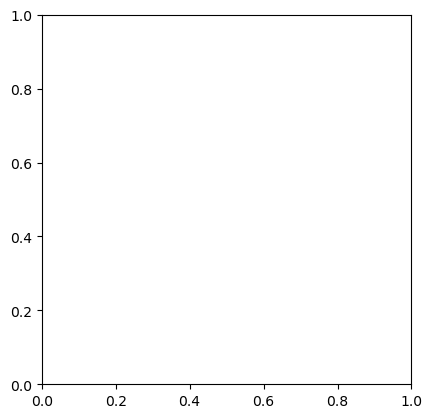

In [47]:
plt.imshow(image)

In [61]:
image.shape

torch.Size([40, 581])

In [67]:
model = nn.Sequential(
    nn.Linear(200,100),
    nn.Linear(100,200)
)

In [74]:
for m in model.modules():
    print(m.weight.data)

AttributeError: 'Sequential' object has no attribute 'weight'

In [77]:
class myModel(nn.Module):
    def __init__(self):
        super()
        self.nn1 = nn.Sequential(
        nn.Linear(200,100),
        nn.Linear(100,200)
        )
    

In [84]:
a = np.array([[[1,2,3,4],[1,2,3,4],[1,2,3,4]],[[1,2,3,4],[1,2,3,4],[2,34,5,6]]])

In [85]:
print(a)

[[[ 1  2  3  4]
  [ 1  2  3  4]
  [ 1  2  3  4]]

 [[ 1  2  3  4]
  [ 1  2  3  4]
  [ 2 34  5  6]]]


In [86]:
a.shape

(2, 3, 4)

In [94]:
a.reshape(6,4)

array([[ 1,  2,  3,  4],
       [ 1,  2,  3,  4],
       [ 1,  2,  3,  4],
       [ 1,  2,  3,  4],
       [ 1,  2,  3,  4],
       [ 2, 34,  5,  6]])

In [98]:
a[0]

array([[1, 2, 3, 4],
       [1, 2, 3, 4],
       [1, 2, 3, 4]])

In [99]:
a[0].reshape(4,3)

array([[1, 2, 3],
       [4, 1, 2],
       [3, 4, 1],
       [2, 3, 4]])

In [102]:
a.reshape(1,2,-1).shape

(1, 2, 12)

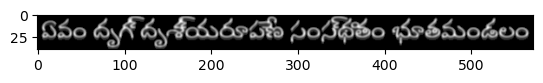

ఏవం దృగ దృశ్యరూపేణ సంస్థితం భూతమండలం


In [140]:
file_num = 1
num = 1

image = torch.load(r"C:/Users/Varun Gopal/Desktop/TeluguOCR_MLProject/KLA_Intern/Dataset/Cropped_Dataset/Images/Image100.pt").to(torch.float32).to(device)
label = torch.load(r"C:/Users/Varun Gopal/Desktop/TeluguOCR_MLProject/KLA_Intern/Dataset/Cropped_Dataset/Labels/Label100.pt").to(device)
plt.imshow(image.cpu(), cmap='gray')
plt.show()
print(index_decoder(label))

In [155]:
cnn_output = cnn(image.unsqueeze(0).unsqueeze(0)).unsqueeze(1).to(device)
print(cnn_output.shape)

RuntimeError: shape '[1, 640, 100]' is invalid for input of size 59520

In [151]:
image.shape

torch.Size([40, 743])

In [157]:
image.unsqueeze(0).unsqueeze(0).shape

torch.Size([1, 1, 40, 743])

In [128]:
def predictor(image):
    layer1=cnn(image)
    layer2=decoder(layer1)
    D=layer2.clone()
    D[:, :, 0:110] = F.softmax(D[:, :, 0:110], dim=2)
    D[:, :, 110:131] = F.softmax(D[:, :, 110:131], dim=2)
    D[:, :, 131:152] = F.softmax(D[:, :, 131:152], dim=2)
    D[:, :, 152:190] = F.softmax(D[:, :, 152:190], dim=2)
    D[:, :, 190:228] = F.softmax(D[:, :, 190:228], dim=2)
    
    print(D.shape)
    s=""
    for i in range(100):
        b=torch.argmax(D[i, 0, 0:110])
        vm=torch.argmax(D[i,0,110:131])
        print(bases[b+2])
        s+=bases[b+2]
#         print(b)
    return s

In [129]:
image

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

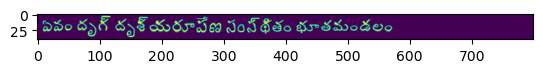

In [132]:
plt.imshow(dataset[100][0].squeeze(0))

TypeError: only integer tensors of a single element can be converted to an index

In [20]:
from PIL import Image, ImageDraw, ImageFont

# Create a blank image with white background
image = Image.new('RGB', (400, 100), color = 'white')

# Load a Telugu font (make sure you have a Telugu font file in .ttf format)
font_path = r"C:\Users\Varun Gopal\Desktop\Noto Sans Telugu Regular\Noto Sans Telugu Regular.ttf"

# Your Telugu text
font_size = 20
font = ImageFont.truetype(font_path, font_size)
# Initialize ImageDraw object
draw = ImageDraw.Draw(image)
telugu_text = "ఏవం దృగ దృశ్యరూపేణ సంస్థితం భూతమండలం"

# Calculate text size and position
text_width, text_height = draw.textsize(telugu_text, font=font)
x = (image.width - text_width) / 2
y = (image.height - text_height) / 2

# Draw text on image
draw.text((x, y), telugu_text, font=font, fill='black')

# Save or display the image
# image.save('telugu_text_image.png')
# image.show()

C:\Users\Varun Gopal\AppData\Local\Temp\ipykernel_14020\640092692.py:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(telugu_text, font=font)


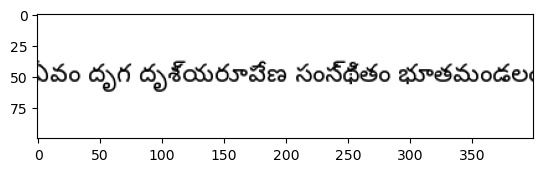

In [21]:
import matplotlib.pyplot as plt
plt.imshow(image)

In [11]:
type(telugu_text)

str

C:\Users\Varun Gopal\AppData\Local\Temp\ipykernel_14020\617373764.py:20: UserWarning: Glyph 108 (l) missing from current font.
  fig.savefig('telugu_text_image.png', dpi=300, bbox_inches='tight')
C:\Users\Varun Gopal\AppData\Local\Temp\ipykernel_14020\617373764.py:20: UserWarning: Glyph 112 (p) missing from current font.
  fig.savefig('telugu_text_image.png', dpi=300, bbox_inches='tight')
C:\Users\Varun Gopal\anaconda3\envs\pytrchkl\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 108 (l) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Varun Gopal\anaconda3\envs\pytrchkl\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 112 (p) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


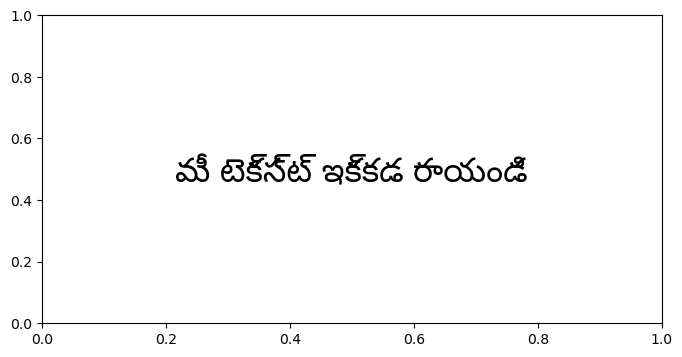

In [25]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# Your Telugu text (Unicode string)
telugu_text = "మీ టెక్స్ట్ ఇక్కడ రాయండి"

# Font path to your Telugu font
font_path = r"C:\Users\Varun Gopal\Desktop\Noto Sans Telugu Regular\Noto Sans Telugu Regular.ttf"

# Create a figure
fig, ax = plt.subplots()

# Display the Telugu text using the specified font file
ax.text(0.5, 0.5, telugu_text, fontsize=24, ha='center', va='center', fontproperties=FontProperties(fname=font_path))

# Adjust figure size (optional)
fig.set_size_inches(8, 4)

# Save the figure as PNG
fig.savefig('telugu_text_image.png', dpi=300, bbox_inches='tight')

# Display or close the figure
plt.show()
# plt.close(fig)  # Use this to close the figure automatically after saving


In [ ]:
g